# Executor for StyleGAN on Fishtank

Fishtank is Gagan's pc, runs in tensorflow 1.15 conda env.

In [1]:
import os
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tflib.init_tf()

In [5]:
network = 'stylegan2_256x256_balanced.pkl'
network_dir = '../'
network = os.path.join(network_dir, network)

In [6]:
if os.path.isfile(network):
    print("Network found, calling load network...")
    _G, _D, Gs = pretrained_networks.load_networks(network)
else:
    print("network not found at: ", network)
    print("In that directory there is: ")
    print(os.listdir(network_dir))

Network found, calling load network...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [7]:
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)

In [8]:
def make_latents(Gs, seed=0, sigma = 1.0, mu = 0.0):
    latents =  sigma * np.random.RandomState(seed).randn(1, Gs.input_shape[1]) + mu
    return latents

In [9]:
images = Gs.run(make_latents(Gs), None, **synthesis_kwargs) # [seed, y, x, rgb]

In [10]:
images.shape

(1, 256, 256, 3)

In [11]:
def plot_image(Gs_output):
    image = PIL.Image.fromarray(Gs_output[0], 'RGB')
    plt.imshow(image)

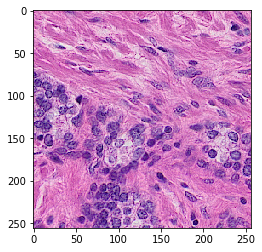

In [12]:
plot_image(images)

In [ ]:
def generate_images_of_mean(network_pkl, count, truncation_psi=0.7, fixed_noise=True):
    count = int(count)
    print('Loading networks from "%s"...' % network_pkl)
    _G, _D, Gs = pretrained_networks.load_networks(network_pkl)
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    rnd = np.random.RandomState(42)
    w_avg = Gs.get_var('dlatent_avg') # [component]

    Gs_syn_kwargs = dnnlib.EasyDict()
    Gs_syn_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_syn_kwargs.randomize_noise = False
    Gs_syn_kwargs.minibatch_size = 1

    # w code means
    latents_dir = '/data/yoder_lab/means_highprob'
    for mean_code in os.listdir(latents_dir):
        if mean_code.endswith('.npy') and mean_code[-9] == 'w':
            w = np.load(os.path.join(latents_dir, mean_code)) # [minibatch, component]
            print('shape: ', w.shape)
            w = w_avg + (w - w_avg) * truncation_psi # [minibatch, layer, component]

            for idx in range(0,count):
                tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
                images = Gs.components.synthesis.run(w, **Gs_syn_kwargs)
                PIL.Image.fromarray(images[0], 'RGB').save('/data/yoder_lab/means_highprob/cat_%s_%04d.png' % (mean_code[-7],idx))

    # z code means
    # for mean_code in os.listdir(latents_dir):
    #     if mean_code.endswith('.npy') and mean_code[5] == 'z':
    #         z = np.load(os.path.join(latents_dir, mean_code))
    #         for idx in range(0,count):
    #             tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
    #             images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
    #             PIL.Image.fromarray(images[0], 'RGB').save('/data/yoder_lab/means/latent_means_w_fixed/cat_%s_%04d.png' % (mean_code[7],idx))